In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import roc_curve,auc

from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [101]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
submission = pd.read_csv('./gender_submission.csv')

In [102]:
combine = [train,test]

In [21]:
#print(train) # 890 * 12
#print(test) #182 * 11

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [16]:
#train.head(3)
#test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [18]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0    549
1    342
Name: Survived, dtype: int64

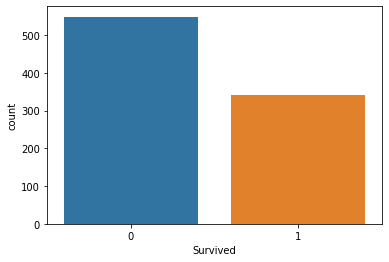

In [43]:
#타겟 변수 시각화
sns.countplot(train['Survived'])
train['Survived'].value_counts()

In [27]:
#결측치 확인
print(train.isnull().sum())
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [44]:
#결측치 제거
train = train.drop(columns='Cabin')
test = test.drop(columns="Cabin")

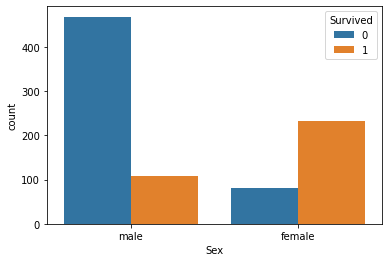

In [31]:
#성별 분포 확인
sns.countplot(data = train, x = "Sex", hue = 'Survived')

In [45]:
#더미 인코딩> 나중에 enconder함수 찾아서 해보기.
train.loc[train['Sex']=='male','Sex'] = 0
train.loc[train['Sex']=='female','Sex'] = 1
test.loc[test['Sex'] == 'male','Sex'] = 0
test.loc[test['Sex'] == 'female','Sex'] = 1

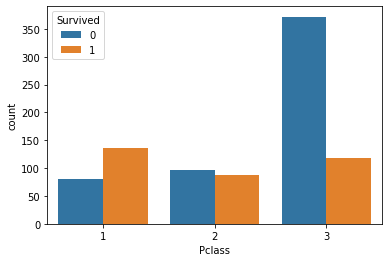

In [34]:
#Pclass 확인
sns.countplot(data = train, x = 'Pclass',hue = 'Survived')

In [46]:
train['Pclass_3'] = (train['Pclass']==3)
train['Pclass_2'] = (train['Pclass']==2)
train['Pclass_1'] = (train['Pclass']==1)

test['Pclass_3'] = (test['Pclass']==3)
test['Pclass_2'] = (test['Pclass']==2)
test['Pclass_1'] = (test['Pclass']==1)

#기존의 Pclass열 제거
train.drop(columns='Pclass',inplace=True)
test.drop(columns='Pclass',inplace=True)

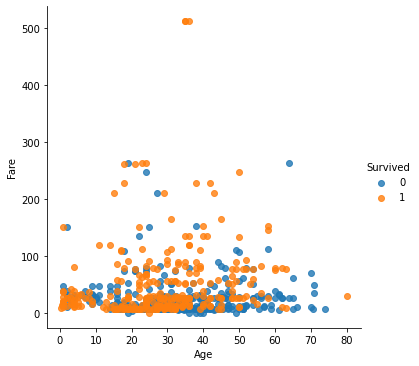

In [47]:
#나이 & 요금
sns.lmplot(data = train, x= 'Age',y='Fare',fit_reg=False, hue = 'Survived')

In [48]:
test.loc[test['Fare'].isnull(),'Fare']=0

In [49]:
#SibSp & Parch > familySize
train['FamilySize'] = train['SibSp']+train['Parch']+1
test['FamilySize'] = test['SibSp']+test['Parch']+1

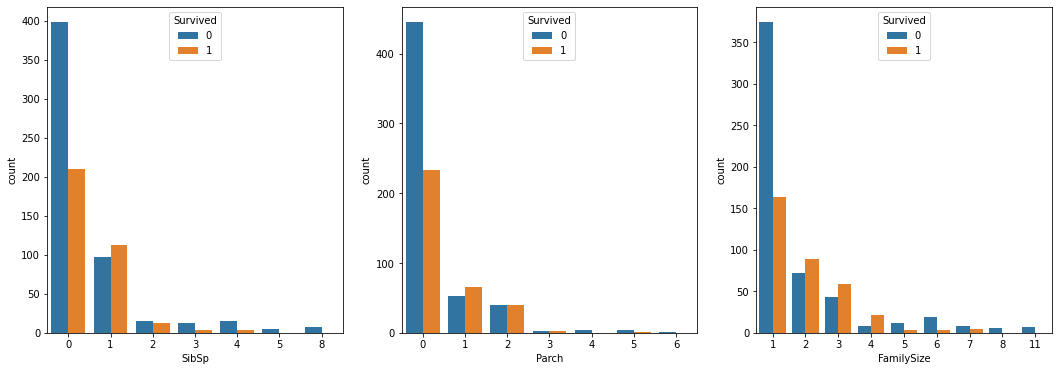

In [50]:
#시각화
figure, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3)
figure.set_size_inches(18,6)
sns.countplot(data = train, x='SibSp',hue = 'Survived',ax = ax1)
sns.countplot(data = train, x = 'Parch',hue = 'Survived',ax = ax2)
sns.countplot(data = train, x = 'FamilySize',hue = 'Survived',ax = ax3)
#왼쪽으로 치우친 분포들

In [51]:
#선착장
train['EmbarkedC'] = train['Embarked'] == 'C'
train['EmbarkedS'] = train['Embarked'] == 'S'
train['EmbarkedQ'] = train['Embarked'] == 'Q'

test['EmbarkedC'] = test['Embarked'] == 'C'
test['EmbarkedS'] = test['Embarked'] == 'S'
test['EmbarkedQ'] = test['Embarked'] == 'Q'

In [53]:
train = train.drop(columns = 'Embarked')
test = test.drop(columns = 'Embarked')

KeyError: ignored

In [63]:
#모델학습
#y_train = train['Survived']
#feature_names = list(test)
#X_train = train[feature_names]
#X_test = test[feature_names]

In [103]:
train = train.drop(['Ticket','Cabin'],axis = 1)
test = test.drop(['Ticket','Cabin'],axis = 1)
combine = [train,test]

In [104]:
for dataset in combine :
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.',expand = False)

In [106]:
pd.crosstab(train['Title'],train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [107]:
for dataset in combine :
    dataset['Title'] = dataset['Title'].replace(['Lady',"countess",'Capt','Col',\
                                                 'Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace('Mile','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')

In [108]:
title_mapping = {'Mr' :1,'Miss':2,"Mrs":3,'Master':4,"Rare":5}
for dataset in combine :
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [109]:
train = train.drop(['Name','PassengerId'],axis = 1)
test = test.drop(['Name'],axis = 1)
combine = [train,test]

In [110]:
for dataset in combine :
    dataset['Sex'] = dataset['Sex'].map({'female':1,'male':0}).astype(int)

In [116]:
guess_ages = np.zeros((2,3))

for dataset in combine :
    for i in range(0,2):
        for j in range(0,3):
            guess_df = dataset[(dataset['Sex']==i) & \
                            (dataset['Pclass'] == j+1)]['Age'].dropna()

            
            age_guess = guess_df.median()
            guess_ages[i,j] = int(age_guess/0.5 + 0.5)*0.5

        for i in range(0,2):
            for j in range(0,3):
                dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                            'Age'] = guess_ages[i,j]

        dataset['Age'] = dataset['Age'].astype(int)


In [118]:
#train['AgeBand'] = pd.cut(train['Age'],5)
train[['AgeBand','Survived']].groupby(['AgeBand'],as_index = False).mean().sort_values(by = 'AgeBand',ascending = True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.594771
1,"(16.0, 32.0]",0.310421
2,"(32.0, 48.0]",0.386473
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [121]:
for dataset in combine :
    dataset.loc[dataset['Age']<=16,'Age'] =0
    dataset.loc[(dataset['Age']>16) & (dataset['Age']<=32), 'Age' ] = 1
    dataset.loc[(dataset['Age']>32) & (dataset['Age']<=48), 'Age' ] = 2
    dataset.loc[(dataset['Age']>48) & (dataset['Age']<=64), 'Age' ] = 3
    dataset.loc[dataset['Age']>64, 'Age']


In [122]:
train = train.drop(['AgeBand'],axis = 1)
combine = [train,test]

In [123]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp']+dataset['Parch'] + 1

In [124]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [125]:
train = train.drop(['Parch','SibSp','FamilySize'],axis = 1)
test = test.drop(['Parch','SibSp','FamilySize'],axis = 1)
combine = [train,test]

In [126]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

In [128]:
freq_port = train.Embarked.dropna().mode()[0]
freq_port

'S'

In [129]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

In [132]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map({'S' :0, "C" :1, "Q" :2}).astype(int)

In [133]:
test['Fare'].fillna(test["Fare"].dropna().median(), inplace = True)

In [134]:
train['FareBand'] = pd.qcut(train['Fare'],4)

In [137]:
for dataset in combine:
    dataset.loc[dataset['Fare']<=7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare']>7.91) & (dataset['Fare']<=14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare']>14.454) & (dataset['Fare']<=31), 'Fare'] = 2
    dataset.loc[dataset['Fare']>31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [138]:
train = train.drop(['FareBand'],axis = 1)
combine = [train,test]

In [141]:
X_train = train.drop("Survived",axis = 1)
y_train = train["Survived"]
X_test = test.drop("PassengerId",axis =1).copy()
X_train.shape,y_train.shape,X_test.shape

((891, 8), (891,), (418, 8))

In [151]:
#모델 spec
logistic = LogisticRegression()
tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()
rf = RandomForestClassifier(n_estimators=100)
voting_estimators = [('logistic',logistic),('tree',tree),('knn',knn),('rf',rf)]
voting = VotingClassifier(estimators= voting_estimators,
                          voting = 'soft')
clf_labels = ['Logistic regression','Decision tree','KNN','Majority voting','RandomForest']

all_clf = [logistic, tree, knn, rf,voting]

In [152]:
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             scoring = 'roc_auc')
    print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
            %(scores.mean(),scores.std(), label))

ROC AUC: 0.854 (+/- 0.037) [Logistic regression]
ROC AUC: 0.837 (+/- 0.067) [Decision tree]
ROC AUC: 0.837 (+/- 0.051) [KNN]
ROC AUC: 0.853 (+/- 0.051) [Majority voting]
ROC AUC: 0.859 (+/- 0.046) [RandomForest]


In [146]:
#colors = ['black','red','blue','green']
#linestyles = [':','--','-','-']

#for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):

    clf.fit(X_train,y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    fpr,tpr,thresholds = roc_curve(y_true = y_test,
                                    y_score = y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color = clr,
             linestyle = ls,
             label = '%s (auc = %0.3f)' % (label, roc_auc))

NameError: ignored

In [149]:
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('tree',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion...
                                        

In [150]:
y_pred = voting.predict(X_test)
acc_log = round(voting.score(X_train,y_train)*100,2)

In [148]:
acc_log

85.63

In [156]:
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [157]:
submission = pd.DataFrame({
    "PassengerId" : test["PassengerId"],
    "Survived": y_pred
})

In [158]:
submission.to_csv('./submission00.csv',index = False)